In [1]:
"""
Author: Andrew Q. Pham, Victor Shia
Email: apham@g.hmc.edu, vshia@g.hmc.edu
Date of Creation: 2/26/20
Description:
    Particle filter implementation to filtering localization estimate
    This code is for teaching purposes for HMC ENGR205 System Simulation Lab 4
    Student code version with parts omitted.
"""


'\nAuthor: Andrew Q. Pham, Victor Shia\nEmail: apham@g.hmc.edu, vshia@g.hmc.edu\nDate of Creation: 2/26/20\nDescription:\n    Particle filter implementation to filtering localization estimate\n    This code is for teaching purposes for HMC ENGR205 System Simulation Lab 4\n    Student code version with parts omitted.\n'

In [6]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import shelve
from utils import *
from prediction import prediction_and_correction_step
from resample import resample_step
import scipy.stats

In [3]:
def propogate_state(x_t_prev, noisy_u_t):
    """Propagate/predict the state based on chosen motion model

    Parameters:
    x_t_prev (np.array)  -- the previous state estimate
    u_t (np.array)       -- the current control input

    Returns:
    x_bar_t (np.array)   -- the predicted state
    """
    """STUDENT CODE START"""
    x_pos_prev, y_pos_prev, x_vel_prev, y_vel_prev, yaw_prev, weight_prev = x_t_prev
    x_acc, yaw_vel = noisy_u_t
    
    x_bar_t = np.zeros(6)
    
    #Propagation does not change the weights
    x_bar_t = x_t_prev + np.array([x_vel_prev * DT,
                                   y_vel_prev * DT,
                                   x_acc * np.cos(yaw_prev) * DT,
                                   x_acc * np.sin(yaw_prev) * DT,
                                   yaw_vel * DT,
                                   weight_prev])
    """STUDENT CODE END"""
    return x_bar_t

In [21]:
def prediction_and_correction_step(x_t_prev, u_t, z_t):
    """Compute the prediction and correction (re-weighting) for the PF

    Parameters:
    x_t_prev (np.array)         -- the previous state estimate
    u_t (np.array)              -- the control input
    z_t (np.array)              -- the current measurement

    Returns:
    x_bar_t (np.array)          -- the predicted state estimate of time t
    """

    """STUDENT CODE START"""
    
    # Adding noise before propagation
    
    x_acc, yaw_vel = u_t
    
    x_bar_t = np.zeros_like(x_t_prev) # N_particles x N_states mtx
    
    # Prediction step
    for i in range(PARTICLES):
        x_acc_noise = np.random.normal(loc = 0, scale = x_acc_noise)
        yaw_vel_noise = np.random.normal(loc = 0, scale = yaw_vel_noise)
        noisy_u_t = np.array([x_acc + x_acc_noise, yaw_vel + yaw_vel_noise])
        x_bar_t[i,:] = propagate_state(x_t_prev[i,:], noisy_u_t)
    
    # Correction
    
    """STUDENT CODE END"""

    return x_bar_t

In [ ]:
def resample_step(x_bar_t):
    """Ressampling step for the PF

    Parameters:
    x_bar_t       (np.array)    -- the predicted state estimate of time t
    """

    """STUDENT CODE START"""
    x_est_t = x_bar_t
    """STUDENT CODE END"""

    return x_est_t

In [ ]:
def moving_average(x, window = 10):
    return np.convolve(x, 1.0 * np.ones(window) / window, 'full')

In [ ]:
filepath = "../E205_Lab_03/logs/"
filename = "2020_2_26__16_59_7"
# filename = "2020_2_26__17_21_59"
data, is_filtered = load_data(filepath + filename)

# Save filtered data so don't have to process unfiltered data everytime
if not is_filtered:
    data = filter_data(data)
    save_data(f_data, filepath+filename+"_filtered.csv")

In [5]:
# Load data into variables
x_lidar = np.array(data["X"])
y_lidar = np.array(data["Y"])
z_lidar = data["Z"]
time_stamps = data["Time Stamp"]
lat_gps = np.array(data["Latitude"])
lon_gps = np.array(data["Longitude"])
yaw_lidar = np.array(data["Yaw"])
pitch_lidar = data["Pitch"]
roll_lidar = data["Roll"]
x_acc = np.array(data["AccelX"])
y_acc = np.array(data["AccelY"])

lat_origin = lat_gps[0]
lon_origin = lon_gps[0]

### TRANSFORMS/EDITS/OVERWRITES
yaw_lidar = (np.array(yaw_lidar) * -1) * np.pi/180
yaw_lidar = our_wrap_to_pi(yaw_lidar)

time_stamps = np.arange(len(time_stamps)) * 0.1

window_size = 3

x_acc = np.convolve(np.array(x_acc), np.ones(3)/3, mode = 'same')
#y_acc = np.convolve(np.array(y_acc), np.ones(3)/3, mode = 'same')

z_x = 5 - (y_lidar*np.cos(yaw_lidar) + x_lidar*np.sin(yaw_lidar))
z_y = -5 - (y_lidar*np.sin(yaw_lidar) - x_lidar*np.cos(yaw_lidar))
z_yaw = yaw_lidar

yaw_vel = our_wrap_to_pi(yaw_lidar[1:]-yaw_lidar[:-1]) / DT
yaw_vel = np.append(yaw_vel, yaw_vel[-1])

NameError: name 'data' is not defined

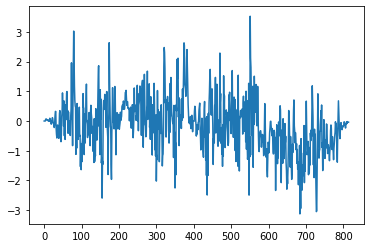

In [18]:
plt.plot(x_acc)

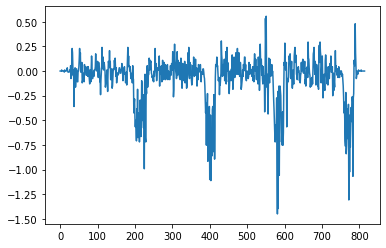

In [19]:
plt.plot(yaw_vel[])

In [24]:
(np.sum(yaw_vel[0:100]**2)/100)**0.5

0.07831223018660441

In [25]:
(np.sum(x_acc[0:100]**2)/100)**0.5

0.6518561531844617

In [9]:
    #  Initialize filter
    """STUDENT CODE START"""
    """STUDENT CODE END"""

    #  Run filter over data
    for t, _ in enumerate(time_stamps):
        # Get control input
        """STUDENT CODE START"""
        """STUDENT CODE END"""

        # Prediction Step
        state_pred_t = prediction_and_correction_step(state_est_t_prev, u_t, z_t)
        state_est_t = resample_step(state_pred_t)

        #  For clarity sake/teaching purposes, we explicitly update t->(t-1)
        state_est_t_prev = state_est_t

        # Log Data
        state_estimates[:, :, t] = state_est_t

        x_gps, y_gps = convert_gps_to_xy(lat_gps=lat_gps[t],
                                         lon_gps=lon_gps[t],
                                         lat_origin=lat_origin,
                                         lon_origin=lon_origin)
        gps_estimates[:, t] = np.array([x_gps, y_gps])
        lidar_pos[:,t] = np.array([z_x, z_y])

    for key in dir():
        try:
            my_shelf[key] = eval(key)
        except Exception:
            #
            # __builtins__, my_shelf, and imported modules can not be shelved.
            #
            print('ERROR shelving: {0}'.format(key))
    my_shelf.close()


    """STUDENT CODE START"""
    # Plot here
    """STUDENT CODE END"""
    return 0
